In [1]:
%matplotlib inline

In [2]:
import numpy
import warnings
import ctypes
import scipy.constants as FCNST
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import healpy as hp

import bifrost
from bifrost.fft import Fft
from bifrost.ring import Ring
from bifrost.romein import Romein
from bifrost.unpack import unpack as Unpack

from bifrost.ndarray import memset_array, copy_array
from bifrost.device import set_device as BFSetGPU, get_device as BFGetGPU, set_devices_no_spin_cpu as BFNoSpinZone

from lsl.common.stations import lwasv

from astropy import units
from astropy.time import Time
import astropy_healpix as ahp
from astropy_healpix import HEALPix
from astropy.constants import c as speed_of_light
from astropy.coordinates import EarthLocation, TETE, SkyCoord, AltAz, Galactic

from pygdsm import GlobalSkyModel

In [3]:
def GenerateLocations(
    lsl_locs, frequencies, ntime, nchan, npol, grid_size=64, grid_resolution=20 / 60.
):
    delta = (2 * grid_size * numpy.sin(numpy.pi * grid_resolution / 360)) ** -1
    chan_wavelengths = speed_of_light.value / frequencies
    sample_grid = chan_wavelengths * delta
    sll = sample_grid[0] / chan_wavelengths[0]
    lsl_locs = lsl_locs.T
    lsl_locsf = lsl_locs[:, numpy.newaxis, numpy.newaxis, :] / sample_grid[numpy.newaxis, numpy.newaxis, :, numpy.newaxis]
    lsl_locsf -= numpy.min(lsl_locsf, axis=3, keepdims=True)

    # Centre locations slightly
    lsl_locsf += (grid_size - numpy.max(lsl_locsf, axis=3, keepdims=True)) / 2.

    # add ntime axis
    locc = numpy.broadcast_to(lsl_locsf, (ntime_gulp, 3, npol, nchan, lsl_locs.shape[1],)).transpose(1, 0, 3, 4, 2)
    return delta, locc, sll


In [4]:
def make_lm_matrix(skymodes1d):
    lm_step = 2.0 / skymodes1d 
    i, j = numpy.meshgrid(numpy.arange(skymodes1d), numpy.arange(skymodes1d))
    lm_matrix = numpy.asarray([i * lm_step - 1.0, j * lm_step - 1.0, numpy.zeros_like(j)])
    lm_matrix = numpy.fft.fftshift(lm_matrix, axes=(1, 2))
    lm_vector = lm_matrix.transpose([1, 2, 0 ])
    lm_vector[..., 2] = numpy.sqrt(1 - lm_vector[..., 0] ** 2 - lm_vector[..., 1] ** 2)
    return lm_vector


In [5]:
def get_phases(lwasv, nchan, nstand, npol):
    phases = numpy.zeros((nchan, nstand, npol), dtype=numpy.complex64)
    for i in range(nstand):
        # X
        a = lwasv.antennas[2 * i + 0]
        delay = a.cable.delay(freq) - a.stand.z / speed_of_light.value
        phases[:, i, 0] = numpy.exp(2j * numpy.pi * freq * delay)
        phases[:, i, 0] /= numpy.sqrt(a.cable.gain(freq))
        if npol == 2:
            # Y
            a = lwasv.antennas[2 * i + 1]
            delay = a.cable.delay(freq) - a.stand.z / speed_of_light.value
            phases[:, i, 1] = numpy.exp(2j * numpy.pi * freq * delay)
            phases[:, i, 1] /= numpy.sqrt(a.cable.gain(freq))
    return phases

In [6]:
# EPICal object
class EPICal:
    """A Calibration Class for EPIC


    Parameters
    ----------
    antenna_locations : array
        A numpy array of antenna locations in units of wavelengths.
        Expected shape (nstand, nchan, npol, 3).
    cal_source_flux : array_like
        An array like of the flux in Jy for each source.
        Expected shape (n_sources, nchan, npol)
    cal_source_locs : array
        A nump array of the (l, m, n) or (l,m ) coordinates for each calibration source.
        Expected shape (n_sources, 2) or (n_sources, 3)
    lm_grid : array
        The (l, m) grid points of the image
        Expected shape (n_pixel, n_pixels, 2) or (n_pixel, n_pixel, 3)
    current_gains : array
        An array of current gains applied to the voltage stream.
        Expected shape (nstand, nchan, npol). Optional, defaults to ones.
    flagged_antennas : array
        An array of integers of the antennas indices corresponding to flagged antennas. Optional
    n_iter : int
        Number of iterations of correlation updates before new gains are solved estimated.
    ref_ant : int 
        The reference antenna for calibration.
    damping_factor : float
        The damping factor used when updating calibration solutions, must be in the range [0, 1]
    phase_fit : bool
        When True, only fits the phase of the calibration.
    
    """
    def __init__(
        self,
        antenna_locations,
        cal_source_flux,
        cal_source_locs,
        lm_grid,
        current_gains=None,
        flagged_antennas=None,
        n_iter=10,
        ref_ant=0,
        damping_factor=0,
        phase_fit=False,
        auto_noise_model=0.0,
        exclude_autos=False,
        fix_holographic_phase=True,
        flatten_array=False,
        conv_thresh=0.000001,
        conv_max_try=2000,
    ):

        self.nstand = antenna_locations.shape[0]
        self.nchan = antenna_locations.shape[1]
        self.npol = antenna_locations.shape[2]
        self.locations = antenna_locations
        
        self.good_ants = numpy.ones(shape=(nstand), dtype=numpy.bool)
        if flagged_antennas is not None:
            self.good_ants[flagged_antennas] = False

        self.cal_source_flux = cal_source_flux
        self.n_cal_sources = self.cal_source_flux.shape[0]
        self.linalg = bifrost.linalg.LinAlg()
        
        if cal_source_locs.shape[-1] == 2:
            tmp_locs = numpy.zeros((self.n_cal_sources, 3))
            tmp_locs[:, :2] = cal_source_locs
            tmp_locs[:, 2] = numpy.sqrt(1 - tmp_locs[:, 0] ** 2 - tmp_locs[:, 1] ** 2)
            cal_source_locs = tmp_locs

        self.cal_source_locs = cal_source_locs

        self.cal_pixel_inds = None
        self.cal_pixel_locs = None

        if lm_grid.shape[2] == 2:
            tmp_lm = numpy.zeros((lm_grid.shape[0], lm_grid.shape[1], 3))
            tmp_lm[:, :, :2] = lm_grid
            tmp_lm[:, :, 2] = numpy.sqrt(1 - tmp_lm[:, :, 0] ** 2 - tmp_lm[:, :, 1]**2)
            lm_grid = tmp_lm
        self.lm_grid = lm_grid

        if current_gains is None:
            current_gains = numpy.ones((self.nstand, self.nchan, self.npol), dtype=numpy.complex64)

        self.current_gains = current_gains
        self.n_iter = n_iter
        self.calibration_loop_count = 0

        self.ref_ant = ref_ant
        self.damping_factor = damping_factor
        self.phase_fit = phase_fit
        self.auto_noise_model = auto_noise_model
        self.exclude_autos = exclude_autos
        self.fix_holographic_phase = fix_holographic_phase
        self.flatten_array = flatten_array
        self.conv_thresh = conv_thresh
        self.conv_max_try = conv_max_try
    
        self.auto_corr = bifrost.zeros((self.nstand, self.nchan, self.npol), dtype=numpy.complex64, space="cuda")
        self.ant_twt = numpy.zeros((self.nstand, self.nchan, self.npol), dtype=numpy.int32)
        
        self.cal_corr = bifrost.zeros(
            (self.nchan, self.npol, self.nstand, self.n_cal_sources),
            dtype=numpy.complex64,
            space="cuda"
        )

    def calculate_model_visibilities(self):
        self.cal_pixel_inds = numpy.ascontiguousarray(
            numpy.atleast_2d(
                numpy.asarray(
                    numpy.unravel_index(
                        numpy.argmin(
                            (self.lm_grid[:, :, 0].reshape(-1, 1) - self.cal_source_locs[numpy.newaxis, :, 0]) ** 2
                            + (self.lm_grid[:, :, 1].reshape(-1, 1) - self.cal_source_locs[numpy.newaxis, :, 1]) ** 2,
                            axis=0,
                        ),
                        self.lm_grid.shape[:2]
                    )
                ).T
            )
        )
        self.cal_pixel_inds = bifrost.ndarray(self.cal_pixel_inds).copy()
        self.cal_pixel_locs = self.lm_grid[self.cal_pixel_inds[:, 0], self.cal_pixel_inds[:, 1], :]

        self.model_vis = numpy.zeros((self.nstand, self.nstand, self.nchan, self.npol), dtype=numpy.complex64)
        uvws = self.locations[numpy.newaxis, :, :, :, :] - self.locations[:, numpy.newaxis, :, :, :]
        self.model_vis = (
            self.cal_source_flux[:, numpy.newaxis, numpy.newaxis, :, :]
            * numpy.exp(
                -1j * 2 * numpy.pi 
                * numpy.sum(
                    self.cal_source_locs[:, numpy.newaxis, numpy.newaxis, numpy.newaxis, numpy.newaxis, :]
                    * uvws[numpy.newaxis, :, : , :, :, :],
                    axis=-1,
                ),
            )
        ).astype(numpy.complex64)

        if self.exclude_autos:
            for ant in range(self.nstand):
                self.model_vis[:, ant, ant, :, :] = 0.0

        # Add phase to flatten array
        if self.flatten_array:
            # TODO: check conjugation
            self.model_vis *= numpy.exp(
                1j * 2 * numpy.pi * uvws[numpy.newaxis, ..., 2]
            )
        return

    def calculate_correlation(self, voltage_stream, calibration_pixel_values):
        """
        
        Parameters
        -----------
        voltage_stream : array
            Array of the antenna voltage stream. Has shape (nchan, npol, nstand, ntimes)
            
        calibration_pixel_values : array
            Array of the e-field image values has shape (n_cal_sources, nchan, npol, ntimes)
        """
        ntimes = voltage_stream.shape[-1]

        self.linalg.matmul(1.0, voltage_stream, calibration_pixel_values.transpose([1,2,3,0]).conj(), 1, self.cal_corr)
        
        self.ant_twt[self.good_ants] += ntimes
        
        if self.exclude_autos:
            bifrost.map(
                "for(auto l=0; l<{ntimes}; l++) {{a(k,i,j) += b(i,j,k,l) * b(i,j,k,l).conj();}}".format(ntimes=ntimes),
                data={"a": self.auto_corr, "b": voltage_stream,},
                axis_names=("i","j", "k"),
                shape=(self.nchan, self.npol, self.nstand),
            )

        self.calibration_loop_count += 1
        
    
    def copy_calibration_pixels(self, efield_cal_image):
        
        ntimes = efield_cal_image.shape[1]
        
        calibration_pixel_values =  bifrost.zeros(
            shape=(self.n_cal_sources, self.nchan, self.npol, ntimes),
            dtype=numpy.complex64,
            space="cuda",
        )

        bifrost.map(
            "a(i,j,k,l) = b(0,l,j,k,c(i,0),c(i,1))",
            data={"a": calibration_pixel_values, "b": efield_cal_image, "c": self.cal_pixel_inds.copy(space="cuda")},
            axis_names=("i", "j", "k", "l"),
            shape=(self.n_cal_sources, self.nchan, self.npol, ntimes),
        )
        
        return calibration_pixel_values

    def estimate_gains(self, input_voltage_stream, efield_image):
        """
        
        Parameters
        -----------
        voltage_stream : bifrost.ndarray
            Array of the antenna voltage stream has dtype ci4. Has shape (ntimes, nchan, nstand, npol)
            
        efield_image : bifrost
            Array of the e-field image has shape (ntime, nchan, npol, npixels, npixels)
        """
        
        if self.cal_pixel_inds is None:
            self.calculate_model_visibilities()
            
        calibration_pixel_values = self.copy_calibration_pixels(efield_image)
        
        input_voltage_stream = input_voltage_stream.transpose([1,3,2,0]).copy()
        input_voltage_stream = input_voltage_stream.copy(space="cuda")
        
        g_voltage_stream = bifrost.ndarray(shape=input_voltage_stream.shape, dtype=numpy.complex64, space="cuda")
        Unpack(input_voltage_stream, g_voltage_stream)

        self.calculate_correlation(g_voltage_stream, calibration_pixel_values)
        
        if self.calibration_loop_count == self.n_iter:
            
            tries = 0
            convergence_delta = 100.0
            temp_gains = numpy.broadcast_to(self.current_gains, (self.n_cal_sources, self.nstand, self.nchan, self.npol))
            
            self.cal_corr = self.cal_corr.copy(space="system").transpose([3, 2, 0, 1]).copy()
            self.auto_corr = self.auto_corr.copy(space="system")
            
            if self.fix_holographic_phase:
                # The holographic images have a silly phase running through them due to not centering when padding. Take it out.
                dl = self.lm_grid[0, 1, 0] - self.lm_grid[0, 0, 0]
                dm = self.lm_grid[1, 0, 1] - self.lm_grid[0, 0, 1]

                phase_fix = numpy.exp(-1j * numpy.pi * (self.cal_pixel_locs[:,0] / dl + self.cal_pixel_locs[:,1] / dm) / 2)
                self.cal_corr = self.cal_corr * phase_fix[:, numpy.newaxis, numpy.newaxis, numpy.newaxis]   
            
            self.cal_corr = self.cal_corr / self.ant_twt[numpy.newaxis] # make it an average
            
            # applying multiplicative gains, these get conjugated when applied
            applied_cal = numpy.conj(self.current_gains)
            
            if self.exclude_autos:
                self.auto_corr = self.auto_corr / self.ant_twt
                
                self.cal_corr -= numpy.exp(
                    1j * 2 * numpy.pi
                    * numpy.sum(
                        self.locations[numpy.newaxis, :, :, :, :2] * self.cal_pixel_locs[:, numpy.newaxis, numpy.newaxis, numpy.newaxis, :2],
                        axis=3,
                    )
                ) * self.auto_corr[numpy.newaxis] * numpy.conj(applied_cal) / self.nstand
            
            while (tries < self.conv_max_try) and (convergence_delta > self.conv_thresh):
                
                prev_gains = temp_gains.copy()

                temp_gains = (
                    self.cal_corr * (self.ant_twt.sum(axis=0, keepdims=True) - self.ant_twt)[numpy.newaxis] # broadcast over the nsources dimension
                    * self.nstand 
                    / numpy.sum(
                        (self.nstand - 1) * self.ant_twt[numpy.newaxis, numpy.newaxis]
                        * numpy.exp(
                            1j * 2 * numpy.pi
                            * numpy.sum(
                                # broadcast the antenna positions and cal_pix_locs up to (n_cal_sources, nstand, nstand, nchan, npol, 2) to match model visibilites
                                self.locations[numpy.newaxis, numpy.newaxis, :, :, :, 0:2] 
                                * self.cal_pixel_locs[:, numpy.newaxis, numpy.newaxis, numpy.newaxis, numpy.newaxis, 0:2],
                                axis=5,
                            )
                        ) * self.model_vis * numpy.conj(applied_cal * prev_gains)[:, numpy.newaxis],
                        axis=2,
                    )
                )

                phasor = temp_gains[:, self.ref_ant] / numpy.abs(temp_gains[:, self.ref_ant])
                temp_gains *= numpy.conj(phasor)[:, numpy.newaxis]
                
                temp_gains = prev_gains * self.damping_factor + temp_gains * (1 - self.damping_factor)
#                 print("nans: ", numpy.isnan(numpy.abs(temp_gains - prev_gains) / numpy.abs(prev_gains)).sum())
                   
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    convergence_delta = numpy.nanmax(numpy.abs(temp_gains - prev_gains) / numpy.abs(prev_gains))
                tries += 1
#                 print(convergence_delta)
            if tries == self.conv_max_try:
                print("Maximum tries exceeded before convergence achieved.")
            else:
                print(f"Converged in {tries} iterations. Final change: {convergence_delta}")
            
            temp_gains = numpy.average(temp_gains, weights=numpy.ones_like(temp_gains), axis=0)
            
            if self.phase_fit:
                # Only fit phase
                temp_gains = temp_gains / NP.abs(self.current_gains)
            
            self.current_gains = numpy.where(
                numpy.isfinite(temp_gains),
                self.current_gains * self.damping_factor + temp_gains * (1 - self.damping_factor),
                self.current_gains,
            )
            if self.phase_fit:
                self.current_gains = self.current_gains / numpy.abs(self.current_gains)
            
            # reset the necessary paramters to start a new calibration loop
            self.calibration_loop_count = 0
            self.auto_corr = bifrost.zeros((self.nstand, self.nchan, self.npol), dtype=numpy.complex64, space="cuda")
            self.ant_twt = numpy.zeros((self.nstand, self.nchan, self.npol), dtype=numpy.int32)

            self.cal_corr = bifrost.zeros(
                (self.nchan, self.npol, self.nstand, self.n_cal_sources),
                dtype=numpy.complex64,
                space="cuda"
            )
        
    def get_gains(self):
        return numpy.conj(self.current_gains).astype(numpy.complex64)

In [7]:
BFSetGPU(0)
# cal_ring = Ring(name="cal_ring", space="cuda")

In [8]:
voltage_file = "/data4/mkolopanis/src/LWA_EPIC/epic_data_voltages.npz"
efield_image = "/data4/mkolopanis/src/LWA_EPIC/epic_efield_image.npz"

In [9]:
voltages = numpy.load(voltage_file, allow_pickle=True)

In [10]:
image = numpy.load(efield_image, allow_pickle=True)

In [11]:
voltage_hdr = voltages["hdr"].item()
img_hdr = image["hdr"].item()

In [12]:
voltages["hdr"], voltages["data"].shape

(array({'time_tag': 297616560436264860, 'seq0': 0, 'chan0': 1022, 'nchan': 4, 'cfreq': 25609999.98729676, 'bw': 100000.0, 'nstand': 256, 'npol': 2, 'nbit': 4, 'complex': True, 'axes': 'time,chan,stand,pol'},
       dtype=object),
 (512, 4, 256, 2))

In [13]:
image["hdr"], image["data"].shape

(array({'time_tag': 297616560436264860, 'seq0': 0, 'chan0': 1022, 'nchan': 4, 'cfreq': 25609999.98729676, 'bw': 100000.0, 'nstand': 256, 'npol': 4, 'nbit': 64, 'complex': True, 'axes': 'time,chan,pol,gridy,gridx', 'grid_size_x': 64, 'grid_size_y': 64, 'sampling_length_x': 0.49999887562843115, 'sampling_length_y': 0.49999887562843115, 'accumulation_time': 61.44, 'FS': 196000000.0, 'latitude': 34.348358, 'longitude': -106.885783, 'telescope': 'LWA-SV', 'data_units': 'UNCALIB', 'pols': ['xx', 'xy', 'yx', 'yy']},
       dtype=object),
 (1, 512, 4, 2, 64, 64))

In [14]:
lwasv_antennas = lwasv.antennas
obstime = Time(img_hdr["time_tag"] / img_hdr["FS"], format="unix")
lon = img_hdr["longitude"] * units.deg
lat = img_hdr["latitude"] * units.deg
grid_size = img_hdr["grid_size_x"]
ntime_gulp = image["data"].shape[1]
chan_bw = img_hdr["bw"]
chan0 = img_hdr["chan0"]
cfreq = img_hdr["cfreq"]
nchan = img_hdr["nchan"]
npol = voltage_hdr["npol"]
npol_image = img_hdr["npol"]
skymodes1d = img_hdr["grid_size_x"]
ant_extent = 1
freq = (cfreq + numpy.arange(nchan) * chan_bw)

point_source=False
ones_test=True

In [15]:
locations = numpy.array([(ant.stand.x, ant.stand.y, ant.stand.z) for ant in lwasv.antennas[::2]])
locations[255, :] = 0.0
nstand = locations.shape[0]
delta, locs, sll = GenerateLocations(locations, freq, ntime_gulp, nchan, npol)

In [16]:
gpu_locs = bifrost.ndarray(locs.astype(numpy.int32).copy(), space="cuda")

phases = get_phases(lwasv, nchan, nstand, npol)
lm_matrix = make_lm_matrix(skymodes1d)

<ipython-input-4-21b95f273059>:7: RuntimeWarning: invalid value encountered in sqrt
  lm_vector[..., 2] = numpy.sqrt(1 - lm_vector[..., 0] ** 2 - lm_vector[..., 1] ** 2)


In [17]:
site_loc = EarthLocation.from_geodetic(
    lwasv.lon * (180.0 / numpy.pi),
    lwasv.lat * (180.0 / numpy.pi),
    height=1511 * units.m,
)

In [18]:
 numpy.asarray(2 * FCNST.Boltzmann * (FCNST.speed_of_light / freq)**2 * 10**26, dtype=numpy.float64)

array([378386.40795936, 375448.63639848, 372544.94554333, 369674.81027073])

In [20]:
if point_source:
    radec = numpy.array([[5.233686583, 0.71094094367], [6.12377129663, 1.02645722192]])
    fluxes = src_flux = numpy.array([20539.0, 19328.0])
    fluxes[1] *= 0.57 # a fudging factor because it is down in the beam
    # radec = radec[1]
    # fluxes = fluxes[1]
    fluxes = numpy.atleast_1d(fluxes)
    radec = numpy.atleast_2d(radec)
    sou_info = SkyCoord(
        ra=radec[:, 0] * units.rad, dec=radec[:, 1] * units.rad, frame="icrs",
    )
else:
  
    gsm2008 = GlobalSkyModel(freq_unit="Hz")
    fluxes = gsm2008.generate(freq)
    fluxes = hp.pixelfunc.ud_grade(fluxes, 16)
    gsm2008_coords = HEALPix(ahp.npix_to_nside(fluxes.shape[1]), frame=Galactic())
    sou_info = gsm2008_coords.healpix_to_skycoord(numpy.arange(gsm2008_coords.npix))
    sou_info = sou_info.transform_to("icrs")
    
    fluxes *= numpy.asarray(2 * FCNST.Boltzmann * (FCNST.speed_of_light / freq)**2 * 10**26, dtype=numpy.float64)[:, numpy.newaxis] # Jy/str


app_coord_data = sou_info.transform_to(
    TETE(location=site_loc, obstime=obstime)
)

In [35]:
lm_coords = numpy.sin(app_coord_data.altaz.zen).reshape(-1, 1)* numpy.asarray([numpy.cos(app_coord_data.altaz.az), numpy.sin(app_coord_data.altaz.az)]).T
good_pix = app_coord_data.altaz.zen.deg <= 90   
lm_coords = lm_coords[good_pix]

if point_source: 
    cal_source_flux = numpy.broadcast_to(fluxes[:, numpy.newaxis, numpy.newaxis], (fluxes.shape[0], nchan, npol))
    
elif ones_test:
    lm_coords= numpy.atleast_2d([0,0])
    cal_source_flux = numpy.asarray([1.])
    cal_source_flux = numpy.broadcast_to(cal_source_flux[:, numpy.newaxis, numpy.newaxis], (cal_source_flux.shape[0], nchan, npol))
    
else:
    cal_source_flux = fluxes[..., good_pix].T
    inds = numpy.argsort(cal_source_flux, axis=0)[:100]
    
    cal_source_flux = numpy.take(cal_source_flux, inds)
    
    cal_source_flux = numpy.broadcast_to(cal_source_flux[:, :, numpy.newaxis], (cal_source_flux.shape[0], nchan, npol))
    
    lm_coords = lm_coords[inds[:, 0]]
    

In [29]:
input_vs = voltages["data"]

if ones_test:
    input_vs = numpy.ones_like(input_vs)
    

In [32]:
voltage_stream_c14 = bifrost.ndarray(shape=input_vs.shape, buffer=input_vs.ctypes.data, native=False, dtype="ci4", space="system")
cal_vs = voltage_stream_c14.copy()
gpu_cal_vs = cal_vs.copy(space="cuda")

voltage_stream_c14 = voltage_stream_c14.transpose([1,3,2,0])
voltage_stream_c14 = voltage_stream_c14.copy()
voltage_stream_c14 = voltage_stream_c14.copy(space="cuda")

vdata = bifrost.ndarray(shape=voltage_stream_c14.shape, dtype=numpy.complex64, space="cuda")
Unpack(voltage_stream_c14, vdata)

voltage_stream = vdata.copy("system")

# voltage_stream = bifrost.ndarray(numpy.ascontiguousarray(voltage_stream.transpose([1,3,2,0])))
# vdata = voltage_stream.copy(space="cuda")
efield_system =  image["data"]
efield_cal_image = bifrost.ndarray(
    image["data"],
    dtype=numpy.complex64,
    space="cuda",
)

In [37]:
max_inds = numpy.ascontiguousarray(
    numpy.atleast_2d(
        numpy.asarray(
            numpy.unravel_index(
                numpy.argmin(
                    (lm_matrix[:, :, 0].reshape(-1, 1) - lm_coords[numpy.newaxis, :, 0]) ** 2
                    + (lm_matrix[:, :, 1].reshape(-1, 1) - lm_coords[numpy.newaxis, :, 1]) ** 2,
                    axis=0,
                ),
                lm_matrix.shape[:2]
            )
        ).T
    )
)

g_inds = bifrost.ndarray(max_inds).copy()
g_inds = g_inds.copy(space="cuda")

In [38]:
max_locations_lm = lm_matrix[max_inds[:, 0], max_inds[:,1], :2]

cal_pixels = efield_system[0,:, :, :, max_inds[:, 0], max_inds[:,1]].transpose([0,2,3,1])
n_cal_sources = max_inds.shape[0]

In [39]:
cal_obj = EPICal(
    locs.transpose(3, 2, 4, 0, 1)[...,0],
    cal_source_flux=cal_source_flux,
    cal_source_locs=lm_coords,
    lm_grid=lm_matrix,
    n_iter=1,
    exclude_autos=True,
    ref_ant=0,
    damping_factor=0.5,
    flatten_array=True,
    current_gains=phases.transpose([1,0,2]),
)

In [40]:
cal_obj.estimate_gains(cal_vs, efield_cal_image)

Converged in 50 iterations. Final change: 7.819825645990034e-07


In [41]:
cal_obj.model_vis.shape

(1, 256, 256, 4, 2)

In [42]:
# for i in range(8):
#     cal_obj.estimate_gains(cal_vs, efield_cal_image)

In [43]:
# cal_obj.estimate_gains(cal_vs, efield_cal_image)

In [44]:
crosspol_pre = bifrost.zeros(
    shape=(ntime_gulp, nchan, npol ** 2, grid_size, grid_size),
    dtype=numpy.complex64,
    space="cuda",
)

image_pre = bifrost.zeros(
    shape=(1, nchan, npol ** 2, grid_size, grid_size),
    dtype=numpy.complex64,
    space="cuda"
)

In [45]:
bifrost.map(
    "a(i,j,p,k,l) += b(0,i,j,p/2,k,l)*b(0,i,j,p%2,k,l).conj()",
    {"a": crosspol_pre, "b": efield_cal_image},
    axis_names=("i", "j", "p", "k", "l"),
    shape=(ntime_gulp, nchan, npol ** 2, grid_size, grid_size),
)
crosspol_pre = crosspol_pre.reshape(
    ntime_gulp, nchan, npol ** 2, grid_size, grid_size
)

bifrost.reduce(crosspol_pre, image_pre, op="sum")

In [46]:
gridded_cal_data = bifrost.zeros(
    shape=(ntime_gulp, nchan, npol, grid_size, grid_size),
    dtype=numpy.complex64,
    space="cuda",
)

In [47]:
cal_gains =  numpy.broadcast_to(
    cal_obj.get_gains().transpose([1,0,2])[numpy.newaxis, :, :, :, numpy.newaxis, numpy.newaxis],
    (ntime_gulp, nchan, nstand, npol, ant_extent, ant_extent)
)

g_cal_gains = bifrost.ndarray(cal_gains).copy()
g_cal_gains = g_cal_gains.copy(space="cuda")


In [48]:
bf_romein_cal = Romein()
bf_romein_cal.init(gpu_locs, g_cal_gains, grid_size, polmajor=False)

In [49]:
bf_romein_cal.execute(gpu_cal_vs, gridded_cal_data)
gridded_cal_data = gridded_cal_data.reshape(ntime_gulp * nchan * npol, grid_size, grid_size)

In [50]:
bf_fft = Fft()
bf_fft.init(gridded_cal_data, gridded_cal_data, axes=(1, 2))
bf_fft.execute(gridded_cal_data,gridded_cal_data, inverse=True)
gridded_cal_data = gridded_cal_data.reshape(
    1, ntime_gulp, nchan, npol, grid_size, grid_size
)

In [51]:
crosspol_post = bifrost.zeros(
    shape=(ntime_gulp, nchan, npol ** 2, grid_size, grid_size),
    dtype=numpy.complex64,
    space="cuda",
)

image_post = bifrost.zeros(
    shape=(1, nchan, npol ** 2, grid_size, grid_size),
    dtype=numpy.complex64,
    space="cuda"
)

In [52]:
 bifrost.map(
    "a(i,j,p,k,l) += b(0,i,j,p/2,k,l)*b(0,i,j,p%2,k,l).conj()",
    {"a": crosspol_post, "b": gridded_cal_data},
    axis_names=("i", "j", "p", "k", "l"),
    shape=(ntime_gulp, nchan, npol ** 2, grid_size, grid_size),
)
    
bifrost.reduce(crosspol_post, image_post, op="sum")    

In [53]:
image_pre = image_pre.copy(space="system")
image_post = image_post.copy(space="system")

In [54]:
image_pre = numpy.fft.fftshift(image_pre, axes=(3, 4))
image_pre =  image_pre[:, :, :, ::-1, :]

In [55]:
image_post = numpy.fft.fftshift(image_post, axes=(3, 4))
image_post =  image_post[:, :, :, ::-1, :]

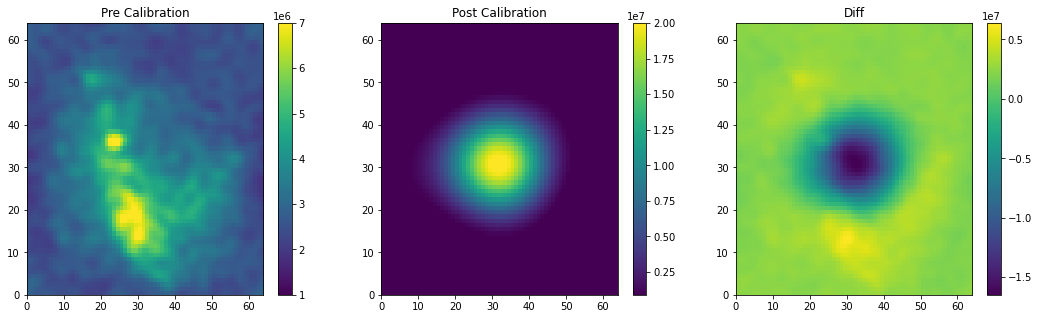

In [73]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5), facecolor="white")

# norm = LogNorm(vmax=1e7, vmin=1e-1)
norm1 = Normalize(vmin=1e6, vmax=7e6)
norm2 = Normalize(vmin=9e5, vmax=2e7)
# norm2 = LogNorm(vmin=1e4, vmax=2e7)
im = ax[0].pcolorfast(image_pre[0,0,0].real, norm=norm1)
fig.colorbar(im, ax=ax[0]);
ax[0].set_title("Pre Calibration");

im = ax[1].pcolorfast(image_post[0,0,0].real, norm=norm2)
fig.colorbar(im, ax=ax[1]);
ax[1].set_title("Post Calibration");

im = ax[2].pcolorfast((image_pre - image_post).real[0,0,0])
fig.colorbar(im, ax=ax[2]);
ax[2].set_title("Diff");


In [57]:
image_pre[0,0,0].real[25, 5] ,image_post[0,0,0].real[25, 5]

(2784605.2, 563220.8)

In [58]:
image_pre[0,0,0].real.min()/1e7, image_pre[0,0,0].real.max()/1e7

(0.1906534375, 0.772711)

In [72]:
image_post[0,0,0].real.min()/1e5, image_post[0,0,0].real.max()/1e7

(5.2979249954223635e-05, 2.066014)

In [60]:
cal_obj.cal_pixel_locs ,cal_obj.cal_source_locs, cal_obj.cal_pixel_inds

(array([[0., 0., 1.]]), array([[0., 0., 1.]]), ndarray([[0, 0]]))

In [126]:
numpy.sqrt(1-cal_obj.cal_pixel_locs[:,0]**2 - cal_obj.cal_pixel_locs[:,1]**2)

<ipython-input-126-ac470c94e825>:1: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(1-cal_obj.cal_pixel_locs[:,0]**2 - cal_obj.cal_pixel_locs[:,1]**2)


array([0.08267973,        nan, 0.15309311,        nan, 0.19263794,
       0.07654655, 0.15309311, 0.08267973, 0.19263794,        nan,
              nan, 0.22963966, 0.21650635, 0.10364452, 0.19263794,
       0.21650635, 0.2400358 , 0.19515619, 0.10364452, 0.12103073,
       0.36975499, 0.27063294, 0.34657927, 0.22963966, 0.08267973,
       0.31093357, 0.3617449 , 0.63584344, 0.22963966, 0.2400358 ,
       0.54036301, 0.10364452, 0.60191751,        nan,        nan,
       0.20728905, 0.41809651, 0.15309311,        nan, 0.44524396,
       0.2914806 ,        nan, 0.37888611, 0.12103073, 0.21423921,
       0.55463248, 0.36975499,        nan, 0.19263794, 0.49607837])

In [127]:
numpy.sqrt(1-lm_coords[:,0]**2 - lm_coords[:,1]**2)

<Quantity [3.45143763e-04, 6.51876830e-02, 6.97580225e-03, 3.62202074e-02,
           1.34122254e-01, 7.42172666e-02, 1.04315817e-01, 9.38265532e-02,
           2.56654032e-02, 4.38736955e-02, 8.25201559e-02, 1.92690950e-01,
           2.36099507e-01, 2.85165745e-02, 2.05745365e-01, 1.63593565e-01,
           1.75019324e-01, 1.43970303e-01, 1.22087947e-01, 1.33362034e-02,
           3.97490851e-01, 3.04647631e-01, 3.56416953e-01, 2.66027010e-01,
           8.38412553e-02, 3.06311667e-01, 3.52256765e-01, 6.42120308e-01,
           1.49925981e-01, 2.56290505e-01, 5.37029823e-01, 5.63634756e-02,
           6.07488513e-01, 7.76477551e-02, 1.57077303e-01, 2.14892458e-01,
           4.19459947e-01, 5.37947626e-02, 5.27417623e-02, 4.60153707e-01,
           3.09558816e-01, 2.55531748e-03, 3.83036864e-01, 1.12646314e-01,
           7.61214625e-02, 5.73307206e-01, 3.24273693e-01, 3.07984837e-02,
           2.89013549e-02, 4.99310373e-01]>

In [ ]:
uvws = cal_obj.locations[numpy.newaxis]  - cal_obj.locations[:, numpy.newaxis]
model_vis = (
    cal_obj.cal_source_flux[:, numpy.newaxis, numpy.newaxis, :, :] 
    * numpy.exp(
        -1j * 2 * numpy.pi 
        * numpy.sum(
            cal_obj.cal_source_locs[:, numpy.newaxis, numpy.newaxis, numpy.newaxis, numpy.newaxis, :]
            * uvws[numpy.newaxis, :, : , :, :, :],
            axis=-1,
        ),
    ).astype(numpy.complex64)
)

In [90]:
numpy.conj(cal_obj.current_gains),phases.transpose([1,0,2])

(array([[[ 0.49122309+0.86924905j,  0.61307464+0.90547675j],
         [ 4.06980638+0.9025616j ,  4.30317741+0.87755126j],
         [ 4.00791165+0.89503407j,  4.42191658+0.80931592j],
         [ 5.72010025+0.84691411j,  4.5953572 +0.70380723j]],
 
        [[-0.1642593 -0.24773979j, -0.27818722+0.45913114j],
         [ 3.35539679-0.12461057j,  3.50684052+0.68207304j],
         [ 3.11995938+0.11997097j,  3.59832731+0.83492901j],
         [ 4.7991405 +0.33436558j,  3.79684201+0.95435336j]],
 
        [[ 1.08094301-0.97513933j,  0.42372486-0.95389689j],
         [ 4.49497761-0.92308667j,  3.76898788-0.60180315j],
         [ 3.95378558-0.88454178j,  3.48308788-0.49617134j],
         [ 5.31490998-0.70165252j,  3.29469906-0.32763438j]],
 
        ...,
 
        [[ 1.78263776+0.48865559j,  1.62268841-0.16522028j],
         [ 5.3161844 +0.36645001j,  4.91483495-0.26624175j],
         [ 5.04443516+0.03377552j,  4.67820439-0.53278614j],
         [ 6.45798551-0.18375247j,  4.43046873-0.73596728j]],